# Llama 3.2 Vision in plain PyTorch

_Note: this should not be used as a reference implementation - it is likely to have minor (and possibly major) discrepancies with the official model (please see the [repo by Meta](https://github.com/meta-llama/llama-models/tree/main))._

### (Preamble)

In [1]:
from dataclasses import dataclass
import json
import math
from pathlib import Path
from typing import Any, Iterable, Optional
import unittest.mock as um
import urllib.request

import matplotlib
import matplotlib.animation
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import seaborn as sns
import torch
from torch import Tensor, tensor
import torch.nn.functional as F

NORM_EPS = 1e-5

## Vision

In [2]:
class vision:
    @dataclass
    class Config:
        # Inputs
        patch_size: int
        image_size: int
        max_tiles: int
        aspect_ratios: list[tuple[int, int]]  # [(ny, nx)]
        image_mean: tuple[float, float, float]
        image_std: tuple[float, float, float]

        # Model
        hidden_size: int
        layers: int
        layers_2: int
        heads: int
        head_size: int
        mlp_size: int
        taps: list[int]

        @property
        def n_aspect(self) -> int:
            return len(self.aspect_ratios)

        @property
        def n_patches(self) -> int:
            return (self.image_size // self.patch_size) ** 2

    @dataclass
    class Layer:
        attn_norm: tuple[Tensor, Tensor]  # weight:(h), bias:(h)
        attn_q: Tensor  # (heads * head_size, h)
        attn_k: Tensor  # (heads * head_size, h)
        attn_v: Tensor  # (heads * head_size, h)
        attn_o: Tensor  # (h, heads * head_size)

        mlp_norm: tuple[Tensor, Tensor]  # weight:(h), bias:(h)
        mlp_up: Tensor  # (mlp_size, h)
        mlp_up_bias: Tensor  # (mlp_size)
        mlp_down: Tensor  # (h, mlp_size)
        mlp_down_bias: Tensor  # (h)

    @dataclass
    class Model:
        patch_embedding: Tensor  # (h, patch_size * patch_size * 3)
        positional_embedding: Tensor  # (n_aspect, max_tiles, n_patches, h)
        class_embedding: Tensor  # (n_aspect, max_tiles, h)
        pre_norm: tuple[Tensor, Tensor]  # weight:(h), bias:(h)
        layers_1: list["vision.Layer"]  # layers x (h)
        post_norm: tuple[Tensor, Tensor]  # weight:(h), bias:(h)
        post_tile_embedding: Tensor  # (n_aspect, max_tiles, h)
        layers_2: list["vision.Layer"]  # layers_2 x (h)

In [3]:
# image: (height, width, 3)
# returns: (image:(n_tiles, n_patches, patch_size*patch_size*3), aspect_ratio_id:())
def preprocess(config: vision.Config, image: Tensor) -> tuple[Tensor, Tensor]:
    image_size = config.image_size
    patch_size = config.patch_size

    # Minimum upscaling, otherwise maximum downscaling
    # - note that the rescaling ifself is slightly different to the MllamaImageProcessor
    #   rules, which seem a little odd (although the choice of aspect should be identical)
    scales = list(
        enumerate(
            min(ny * image_size / image.shape[0], nx * image_size / image.shape[1])
            for ny, nx in config.aspect_ratios
        )
    )
    if any(s >= 1 for _, s in scales):
        aspect_ratio_id, scale = min(
            (x for x in scales if x[1] >= 1), key=lambda x: (x[1], x[0])
        )
    else:
        aspect_ratio_id, scale = max(scales, key=lambda x: (x[1], -x[0]))
    image = F.interpolate(
        image.movedim(-1, 0)[None], scale_factor=scale, mode="bilinear"
    ).squeeze(0).movedim(0, -1)

    # Padding
    ny = math.ceil(image.shape[0] / image_size)
    nx = math.ceil(image.shape[1] / image_size)
    image = F.pad(
        image,
        (0, 0, 0, nx * image_size - image.shape[1], 0, ny * image_size - image.shape[0]),
    )

    # Rescale
    image = (
        (image / 255) - tensor(config.image_mean)
    ) / tensor(config.image_std)

    image = (
        image.reshape(
            ny, image_size//patch_size, patch_size,
            nx, image_size//patch_size, patch_size,
            3,
        )
        .permute(0, 3, 1, 4, 2, 5, 6)
        .flatten(0, 1)
        .flatten(1, 2)
        .flatten(2, 4)
    )
    return image, tensor(aspect_ratio_id)

In [4]:
def vision_transformer(
    config: vision.Config,
    layers: list[vision.Layer],
    hidden: Tensor,
    attn_mask: Tensor,
) -> list[Tensor]:
    hiddens = [hidden.clone()]
    for layer in layers:
        z = F.layer_norm(hidden, hidden.shape[-1:], *layer.attn_norm)
        q, k, v = (
            (z @ m.T).view(-1, config.heads, config.head_size).transpose(-2, -3)
            for m in (layer.attn_q, layer.attn_k, layer.attn_v)
        )
        # Add dummy batch axis for torch performance
        mix = F.scaled_dot_product_attention(
            q[None], k[None], v[None], attn_mask=attn_mask
        ).squeeze(0)
        hidden += mix.transpose(-2, -3).flatten(start_dim=-2) @ layer.attn_o.T

        z = F.layer_norm(hidden, hidden.shape[-1:], *layer.mlp_norm)
        z = F.gelu(z @ layer.mlp_up.T + layer.mlp_up_bias)
        hidden += z @ layer.mlp_down.T + layer.mlp_down_bias
        hiddens.append(hidden.clone())
    return hiddens


def vision_model(
    config: vision.Config,
    params: vision.Model,
    image: Tensor,
    aspect_ratio_id: Tensor,
) -> Tensor:
    # Patch embedding
    patches = (  # (n_tiles, n_patches, hidden_size)
        image.to(params.patch_embedding.dtype) @ params.patch_embedding.T
    )
    patches += params.positional_embedding[aspect_ratio_id, : patches.shape[0]]
    class_embedding = params.class_embedding[
        aspect_ratio_id, : patches.shape[0], None
    ]
    patches = torch.cat([class_embedding, patches], dim=-2)
    patches = F.layer_norm(patches, patches.shape[-1:], *params.pre_norm)

    # Pad and mask
    npad = -(patches.shape[-2] % -8)
    mask = F.pad(
        torch.ones(patches.shape[:-1], dtype=torch.bool, device=patches.device),
        (0, npad),
    ).flatten()
    mask = (mask[:, None] | mask).to(patches.dtype).log()
    hidden = F.pad(patches, (0, 0, 0, npad)).flatten(end_dim=-2)

    # 'Transformer' stack
    hiddens_1 = vision_transformer(config, params.layers_1, hidden, attn_mask=mask)
    hidden = hiddens_1[-1]

    # Intermediate ops
    hidden = F.layer_norm(hidden, hidden.shape[-1:], *params.post_norm)
    hidden.view(config.max_tiles, -1, config.hidden_size).add_(
        params.post_tile_embedding[aspect_ratio_id, : patches.shape[0], None]
    )

    # 'Global Transformer' stack
    hidden = vision_transformer(config, params.layers_2, hidden, attn_mask=mask)[-1]

    # Concat-interleave intermediate hiddens
    hidden_taps = torch.stack([hiddens_1[t] for t in config.taps], dim=-1).flatten(-2)
    hidden = torch.cat([hidden, hidden_taps], dim=-1)

    # Remove padding
    hidden = hidden.unflatten(0, [config.max_tiles, -1])[:, : patches.shape[-2]]

    return hidden

## Text

In [5]:
class text:
    @dataclass
    class Config:
        hidden_size: int
        layers: int
        q_heads_per_kv_head: int
        kv_heads: int
        head_size: int
        rope_angular_frequency: list[float]
        mlp_size: int
        cross_attention_layers: list[int]
        vocab_size: int

        @property
        def q_heads(self) -> int:
            return self.q_heads_per_kv_head * self.kv_heads

    @dataclass
    class Layer:
        attn_norm: Tensor  # (h)
        attn_q: Tensor  # (q_heads_per_kv_head * kv_heads * head_size, h)
        attn_k: Tensor  # (kv_heads * head_size, h)
        attn_v: Tensor  # (kv_heads * head_size, h)
        attn_o: Tensor  # (h, q_heads_per_kv_head * kv_heads * head_size)
        attn_q_norm: Optional[Tensor]  # (head_size)
        attn_k_norm: Optional[Tensor]  # (head_size)

        mlp_norm: Tensor  # (h)
        mlp_up: Tensor  # (mlp_size, h)
        mlp_gate: Tensor  # (mlp_size, h)
        mlp_down: Tensor  # (h, mlp_size)

    @dataclass
    class Model:
        embedding: Tensor  # (vocab_size+, h)
        layers: list["text.Layer"]  # (h)
        final_norm: Tensor  # (h)
        unembedding: Tensor  # (vocab_size, h)


def text_transformer(
    config: text.Config,
    layers: list[text.Layer],
    vision_out: Tensor,  # (vis_length, hidden_size)
    kv_cache: Tensor,  # (2, n_layers, kv_heads, seq_length, head_size)
    hidden: Tensor,  # (d_seq_length, hidden_size)
) -> Tensor:
    pos_id = torch.arange(
        kv_cache.shape[-2] - hidden.shape[-2], kv_cache.shape[-2],
        device=hidden.device,
    )
    rope_angle = pos_id[:, None] * tensor(
        config.rope_angular_frequency, device=hidden.device
    )
    cos, sin = rope_angle.cos().to(hidden.dtype), rope_angle.sin().to(hidden.dtype)
    def rotate(z: Tensor) -> Tensor:
        zx, zy = z.unflatten(-1, (2, -1)).movedim(-2, 0)
        return torch.cat([zx * cos - zy * sin, zy * cos + zx * sin], -1)

    for layer_idx, layer in enumerate(layers):
        cross_attn = layer_idx in config.cross_attention_layers
        input_q = F.rms_norm(hidden, hidden.shape[-1:], layer.attn_norm, eps=NORM_EPS)
        input_kv = vision_out if cross_attn else input_q
        q, k, v = (
            (z @ m.T).view(-1, nh, config.head_size).transpose(-2, -3)
            for m, nh, z in (
                (layer.attn_q, config.q_heads, input_q),
                (layer.attn_k, config.kv_heads, input_kv),
                (layer.attn_v, config.kv_heads, input_kv),
            )
        )
        if cross_attn:
            q = F.rms_norm(q, q.shape[-1:], layer.attn_q_norm, eps=NORM_EPS)
            k = F.rms_norm(k, k.shape[-1:], layer.attn_k_norm, eps=NORM_EPS)
        else:
            q, k = rotate(q), rotate(k)
            kv_cache[:, layer_idx, :, -k.shape[-2]:] = torch.stack([k, v])
            k, v = kv_cache[:, layer_idx]

        # Add dummy batch axis for torch performance
        mix = F.scaled_dot_product_attention(
            q[None], k[None], v[None],
            is_causal=q.shape[-2] > 1 and not cross_attn, enable_gqa=True
        ).squeeze(0)
        hidden += mix.transpose(-2, -3).flatten(start_dim=-2) @ layer.attn_o.T

        z = F.rms_norm(hidden, hidden.shape[-1:], layer.mlp_norm, eps=NORM_EPS)
        z = F.silu(z @ layer.mlp_gate.T) * (z @ layer.mlp_up.T)
        hidden += z @ layer.mlp_down.T
    return hidden


def create_kv_cache(config: text.Config, max_tokens: int, device: torch.device, dtype: torch.dtype) -> Tensor:
    return torch.zeros(
        (2, config.layers, config.kv_heads, max_tokens, config.head_size),
        device=device,
        dtype=dtype,
    )

def text_model(
    config: text.Config,
    params: text.Model,
    vision_out: Tensor,
    kv_cache: Tensor,
    text: Tensor,
) -> Tensor:
    hidden = params.embedding[text]
    hidden = text_transformer(config, params.layers, vision_out, kv_cache, hidden)
    hidden = F.rms_norm(hidden, hidden.shape[-1:], params.final_norm, eps=NORM_EPS)
    return hidden @ params.unembedding.T

## VLM

In [6]:
class vlm:
    @dataclass
    class Config:
        vision: vision.Config
        text: text.Config
        device: torch.device
        dtype: torch.dtype

    @dataclass
    class Model:
        vision: vision.Model  # (h=h_vision)
        vision_text_projection: Tensor  # (h_text, h_vision)
        vision_text_projection_bias: Tensor  # (h_text)
        text: text.Model  # (h=h_text)

    @dataclass
    class Inputs:
        image: Tensor  # (n_tiles, 3, image_size, image_size)
        aspect_ratio_id: Tensor  # ()
        text: Tensor  # (seq_len; int64)

        def to(self, device: torch.device) -> "vlm.Inputs":
            return type(self)(**{k: v.to(device) for k, v in self.__dict__.items()})


def generate(config: vlm.Config, params: vlm.Model, inputs: vlm.Inputs, n_generated: int) -> Tensor:
    with torch.no_grad():
        vision_out = vision_model(config.vision, params.vision, inputs.image, inputs.aspect_ratio_id)
        vision_out = (
            vision_out @ params.vision_text_projection.T + params.vision_text_projection_bias
        ).flatten(end_dim=-2)

        kv_cache = create_kv_cache(
            config.text, max_tokens=inputs.text.shape[0] + n_generated - 1, device=config.device, dtype=config.dtype
        )
        text = torch.cat([inputs.text, torch.zeros(n_generated, dtype=torch.int64, device=config.device)])
        idx0, idx1 = 0, inputs.text.shape[0]
        for _ in range(n_generated):
            logits = text_model(config.text, params.text, vision_out, kv_cache[:, :, :, :idx1], text[idx0:idx1])
            idx0, idx1 = idx1, idx1 + 1
            text[idx0:idx1] = logits[-1:].argmax(-1)
        return text

## Demo

### Conversion from huggingface (SKIP!)

In [7]:
import huggingface_hub
import safetensors.torch
import tokenizers


def _load_parameters(model_name: str) -> dict[str, Tensor]:
    index = json.loads(Path(huggingface_hub.hf_hub_download(model_name, "model.safetensors.index.json")).read_text())
    params = {}
    for file in sorted(set(index["weight_map"].values())):
        params.update(safetensors.torch.load_file(huggingface_hub.hf_hub_download(model_name, file)))
    return params


def _load_config(model_name: str, name: str) -> dict[str, Any]:
    return json.loads(Path(huggingface_hub.hf_hub_download(model_name, name)).read_text())


def _rope_angular_frequency(config: dict[str, Any]) -> list[float]:
    head_size = config["hidden_size"] // config["num_attention_heads"]
    freq = config["rope_theta"] ** -(
        torch.arange(0, head_size, 2, dtype=torch.float) / head_size
    )
    s = config["rope_scaling"]
    z = (
        s["original_max_position_embeddings"] * freq / (2 * torch.pi) - s["low_freq_factor"]
    ) / (s["high_freq_factor"] - s["low_freq_factor"])
    freq *= torch.lerp(tensor(1 / s["factor"]), tensor(1.0), z.clip(0, 1))
    return freq.tolist()


def config_from_huggingface(model_name: str, device: torch.device, dtype: torch.dtype) -> vlm.Config:
    config = _load_config(model_name, "config.json")
    preprocessor_config = _load_config(model_name, "preprocessor_config.json")
    text_config = config["text_config"]
    vision_config = config["vision_config"]

    assert vision_config["hidden_act"] == "gelu"
    assert text_config["hidden_act"] == "silu"
    assert text_config["rms_norm_eps"] == NORM_EPS

    return vlm.Config(
        vision=vision.Config(
            # Inputs
            patch_size=vision_config["patch_size"],
            image_size=vision_config["image_size"],
            max_tiles=vision_config["max_num_tiles"],
            aspect_ratios=vision_config["supported_aspect_ratios"],
            image_mean=preprocessor_config["image_mean"],
            image_std=preprocessor_config["image_std"],
            # Model
            hidden_size=vision_config["hidden_size"],
            layers=vision_config["num_hidden_layers"],
            layers_2=vision_config["num_global_layers"],
            heads=vision_config["attention_heads"],
            head_size=(
                vision_config["hidden_size"] // vision_config["attention_heads"]
            ),
            mlp_size=vision_config["intermediate_size"],
            taps=vision_config["intermediate_layers_indices"],
        ),
        text=text.Config(
            hidden_size=text_config["hidden_size"],
            layers=text_config["num_hidden_layers"],
            q_heads_per_kv_head=(
                text_config["num_attention_heads"]
                // text_config["num_key_value_heads"]
            ),
            kv_heads=text_config["num_key_value_heads"],
            head_size=(
                text_config["hidden_size"] // text_config["num_attention_heads"]
            ),
            rope_angular_frequency=_rope_angular_frequency(text_config),
            mlp_size=text_config["intermediate_size"],
            cross_attention_layers=text_config["cross_attention_layers"],
            vocab_size=text_config["vocab_size"],
        ),
        device=device,
        dtype=dtype,
    )


def params_from_huggingface(model_name: str, c: vlm.Config) -> vlm.Model:
    p = {k: v.to(device=c.device, dtype=c.dtype) for k, v in _load_parameters(model_name).items()}
    cv = c.vision

    ## Vision

    patch_embedding = p["vision_model.patch_embedding.weight"].movedim(1, -1).flatten(start_dim=1)

    def _layer_norm(name: str) -> tuple[Tensor, Tensor]:
        return (p[f"{name}.weight"], p[f"{name}.bias"])

    # Merge positional embeddings
    g = "vision_model.gated_positional_embedding"
    g_gate = p[f"{g}.gate"].tanh().reshape(())
    gated_embeddings = (
        p[f"{g}.embedding"] * (1 - g_gate)
        + p[f"{g}.tile_embedding.weight"].reshape(
            cv.n_aspect + 1, cv.max_tiles, cv.n_patches + 1, cv.hidden_size
        )[1:]
        * g_gate
    )
    t = "vision_model.pre_tile_positional_embedding"
    t_gate = p[f"{t}.gate"].tanh()
    vision_positional_embedding = (
        p[f"{t}.embedding.weight"].reshape(
            cv.n_aspect + 1, cv.max_tiles, 1, cv.hidden_size
        )[1:]
        * t_gate
        + gated_embeddings[..., 1:, :]
    )
    vision_class_embedding = (
        p["vision_model.class_embedding"] + gated_embeddings[..., 0, :]
    )

    def _vision_layer(name: str) -> vision.Layer:
        layer = vision.Layer(
            attn_norm=_layer_norm(f"{name}.input_layernorm"),
            attn_q=p[f"{name}.self_attn.q_proj.weight"],
            attn_k=p[f"{name}.self_attn.k_proj.weight"],
            attn_v=p[f"{name}.self_attn.v_proj.weight"],
            attn_o=p[f"{name}.self_attn.o_proj.weight"],
            mlp_norm=_layer_norm(f"{name}.post_attention_layernorm"),
            mlp_up=p[f"{name}.mlp.fc1.weight"],
            mlp_up_bias=p[f"{name}.mlp.fc1.bias"],
            mlp_down=p[f"{name}.mlp.fc2.weight"],
            mlp_down_bias=p[f"{name}.mlp.fc2.bias"],
        )
        # Merge the gate into the final projection
        if f"{name}.gate_attn" in p:
            layer.attn_o = layer.attn_o * p[f"{name}.gate_attn"].tanh()
            layer.mlp_down = layer.mlp_down * p[f"{name}.gate_ffn"].tanh()
            layer.mlp_down_bias = layer.mlp_down_bias * p[f"{name}.gate_ffn"].tanh()
        return layer

    vision_pre_norm = _layer_norm("vision_model.layernorm_pre")
    layers_1 = [
        _vision_layer(f"vision_model.transformer.layers.{i}") for i in range(cv.layers)
    ]
    vision_post_norm = _layer_norm("vision_model.layernorm_post")
    vision_post_tile_embedding = (
        p["vision_model.post_tile_positional_embedding.gate"].tanh()
        * p["vision_model.post_tile_positional_embedding.embedding.weight"]
    ).view(len(cv.aspect_ratios) + 1, cv.max_tiles, cv.hidden_size)[1:]
    layers_2 = [
        _vision_layer(f"vision_model.global_transformer.layers.{i}")
        for i in range(cv.layers_2)
    ]

    ## Language

    def _text_layer(n: int) -> text.Layer:
        name = f"language_model.model.layers.{n}"
        if n in c.text.cross_attention_layers:
            # Merge the gates into the linear projections
            return text.Layer(
                attn_norm=p[f"{name}.input_layernorm.weight"],
                attn_q=p[f"{name}.cross_attn.q_proj.weight"],
                attn_k=p[f"{name}.cross_attn.k_proj.weight"],
                attn_v=p[f"{name}.cross_attn.v_proj.weight"],
                attn_o=(
                    p[f"{name}.cross_attn.o_proj.weight"]
                    * p[f"{name}.cross_attn_attn_gate"].tanh()
                ),
                attn_q_norm=p[f"{name}.cross_attn.q_norm.weight"],
                attn_k_norm=p[f"{name}.cross_attn.k_norm.weight"],
                mlp_norm=p[f"{name}.post_attention_layernorm.weight"],
                mlp_up=p[f"{name}.mlp.up_proj.weight"],
                mlp_gate=p[f"{name}.mlp.gate_proj.weight"],
                mlp_down=(
                    # WARNING - IN PLACE
                    p[f"{name}.mlp.down_proj.weight"].mul_(p[f"{name}.cross_attn_mlp_gate"].tanh())
                ),
            )
        return text.Layer(
            attn_norm=p[f"{name}.input_layernorm.weight"],
            attn_q=p[f"{name}.self_attn.q_proj.weight"],
            attn_k=p[f"{name}.self_attn.k_proj.weight"],
            attn_v=p[f"{name}.self_attn.v_proj.weight"],
            attn_o=p[f"{name}.self_attn.o_proj.weight"],
            attn_q_norm=None,
            attn_k_norm=None,
            mlp_norm=p[f"{name}.post_attention_layernorm.weight"],
            mlp_up=p[f"{name}.mlp.up_proj.weight"],
            mlp_gate=p[f"{name}.mlp.gate_proj.weight"],
            mlp_down=p[f"{name}.mlp.down_proj.weight"],
        )

    ## Result

    return vlm.Model(
        vision=vision.Model(
            patch_embedding=patch_embedding,
            positional_embedding=vision_positional_embedding,
            class_embedding=vision_class_embedding,
            pre_norm=vision_pre_norm,
            layers_1=layers_1,
            post_norm=vision_post_norm,
            post_tile_embedding=vision_post_tile_embedding,
            layers_2=layers_2,
        ),
        vision_text_projection=p["multi_modal_projector.weight"],
        vision_text_projection_bias=p["multi_modal_projector.bias"],
        text=text.Model(
            embedding=p["language_model.model.embed_tokens.weight"],
            layers=[_text_layer(n) for n in range(c.text.layers)],
            final_norm=p["language_model.model.norm.weight"],
            unembedding=p["language_model.lm_head.weight"],
        ),
    )


def get_inputs(
    config: vlm.Config,
    tokenizer: tokenizers.Tokenizer,
    image: PIL.Image.Image,
    text: str,
) -> vlm.Inputs:
    image, aspect_ratio_id = preprocess(config.vision, tensor(np.asarray(image)[..., :3]))
    return vlm.Inputs(
        image=image,
        aspect_ratio_id=aspect_ratio_id,
        text=tensor(tokenizer.encode(text).ids),
    )

### Load and test

In [8]:
model_name = "meta-llama/Llama-3.2-11B-Vision-Instruct"
config = config_from_huggingface(
    model_name,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    dtype=torch.bfloat16 if torch.cuda.is_available() else torch.float32,
)
if "params" in globals():
    del params
params = params_from_huggingface(model_name, config)
tokenizer = tokenizers.Tokenizer.from_pretrained(model_name)

In [9]:
image_url = "https://graphcore-research.github.io/assets/images/posts/2024-11/potm/context-parallelism/fig-1b.png"
prompt = "<|image|><|begin_of_text|>How much better is CP16 than CP8 for context length 1M?<|eot_id|>\\n<|start_header_id|>assistant<|end_header_id|>"

image_url = "https://www.graphcore.ai/hubfs/working-gc.jpg"
prompt = "<|image|><|begin_of_text|>How many people in the picture?<|eot_id|>\\n<|start_header_id|>assistant<|end_header_id|>"
prompt = "<|image|><|begin_of_text|>What colour shirt is the person to the left of the laptop wearing?<|eot_id|>\\n<|start_header_id|>assistant<|end_header_id|>"

image = PIL.Image.open(urllib.request.urlopen(image_url))

In [10]:
inputs = get_inputs(config, tokenizer, image, prompt).to(config.device)
out = generate(config, params, inputs, n_generated=20)
print(tokenizer.decode(out.tolist(), skip_special_tokens=True))

What colour shirt is the person to the left of the laptop wearing?\nassistant

The person to the left of the laptop is wearing a blue-green t-shirt. The shirt is


## Analysis

### (Preamble)

In [11]:
matplotlib.rcParams.update(
    {"axes.spines.top": False, "axes.spines.right": False, "legend.frameon": False},
)
def save(name: str) -> None:
    out = Path("img")
    out.mkdir(exist_ok=True)
    plt.savefig(out / f"{name}.png", bbox_inches="tight")

def quadplot(img: Tensor) -> Iterable[tuple[Tensor, matplotlib.axes.Axes]]:
    fig = plt.figure(figsize=(12, 12))
    for itile, gtile in zip(img, matplotlib.gridspec.GridSpec(2, 2, wspace=0.01, hspace=0.01)):
        ax = fig.add_subplot(gtile)
        ax.axis("off")
        yield itile, ax

def kmeans(data: Tensor, clusters: int, steps: int) -> tuple[Tensor, Tensor]:
    data = data.float()
    n, d = data.shape
    centroids = data[torch.randint(0, n, size=(clusters,), device=data.device)].clone()
    ids = torch.cdist(data, centroids).argmin(-1)
    for _ in range(steps):
        centroids.scatter_add_(0, ids[:, None].expand((-1, d)), data)
        counts = torch.ones(clusters, dtype=ids.dtype, device=data.device)
        counts.scatter_add_(0, ids, torch.ones_like(ids))
        centroids.div_(counts[:, None])
        ids = torch.cdist(data, centroids).argmin(-1)
    return ids, centroids

### Preprocessing

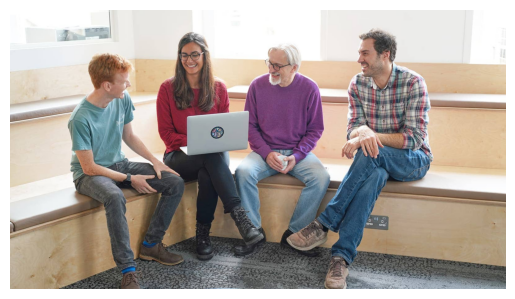

In [12]:
plt.imshow(tensor(np.array(image)))
plt.axis("off")
save("image")

In [13]:
print("image_size", f"{config.vision.image_size}x{config.vision.image_size}")
print("rescaling_mean", "[" + ", ".join("{:.2f}".format(x) for x in config.vision.image_mean) + "]")
print("rescaling_std", "[" + ", ".join("{:.2f}".format(x) for x in config.vision.image_std) + "]")

image_size 560x560
rescaling_mean [0.48, 0.46, 0.41]
rescaling_std [0.27, 0.26, 0.28]


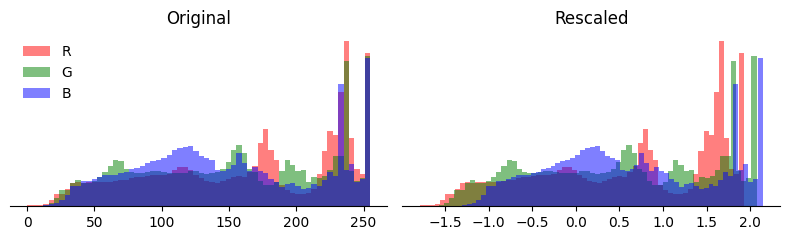

In [33]:
_image = tensor(np.asarray(image)[..., :3])

norm_image = (
    (_image / 255) - tensor(config.vision.image_mean)
) / tensor(config.vision.image_std)

_, axs = plt.subplots(ncols=2, figsize=(8, 2.5), sharey=True)
for title, ax, _img in [("Original", axs[0], _image), ("Rescaled", axs[1], norm_image)]:
    for _color, _i in zip("rgb", _img.flatten(end_dim=-2).T):
        ax.hist(_i, color=_color, bins=64, alpha=.5, label=_color.upper())
        ax.set_yticks([])
        ax.spines["left"].set_visible(False)
        ax.set_title(title)
axs[0].legend()
plt.tight_layout()
save("pre_rescaling")

### Patch embedding

In [15]:
print("patch_size", f"{config.vision.patch_size}x{config.vision.patch_size}")
print("n_patches", f"{config.vision.n_patches}")

patch_size 14x14
n_patches 1600


In [16]:
img = torch.zeros((4, 560, 560, 3)); print(tuple(img.shape))
img = img.reshape(4, 40, 14, 40, 14, 3); print(tuple(img.shape))
img = img.permute(0, 1, 3, 2, 4, 5); print(tuple(img.shape))
img = img.flatten(1, 2).flatten(2, 4); print(tuple(img.shape))

(4, 560, 560, 3)
(4, 40, 14, 40, 14, 3)
(4, 40, 40, 14, 14, 3)
(4, 1600, 588)


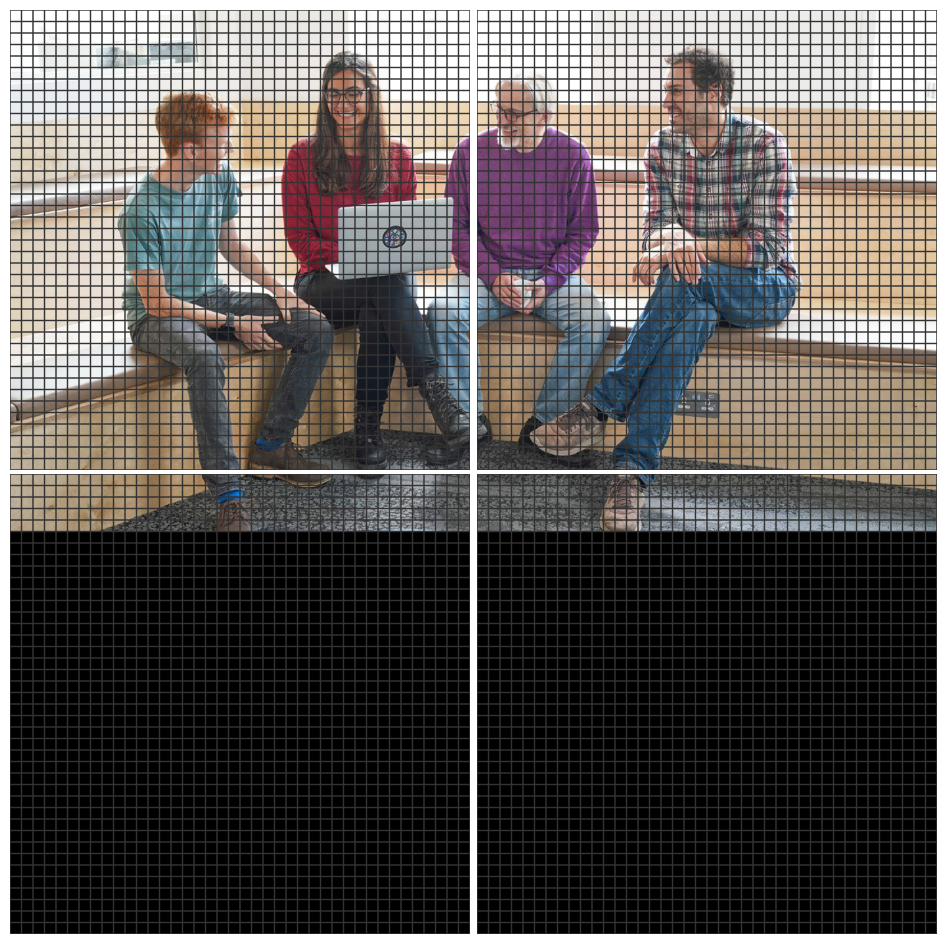

In [17]:
patch_size = config.vision.patch_size
npatch = config.vision.image_size // config.vision.patch_size

img = inputs.image.reshape(-1, npatch, npatch, patch_size, patch_size, 3).detach().cpu().float()
img = img * tensor(config.vision.image_std) + tensor(config.vision.image_mean)
pad = tensor([0.2, 0.2, 0.2]).reshape(1, 1, 1, 1, 1, -1)
img = torch.cat([pad.expand(img.shape)[..., :1, :], img, pad.expand(img.shape)[..., :1, :]], dim=-2)
img = torch.cat([pad.expand(img.shape)[..., :1, :, :], img, pad.expand(img.shape)[..., :1, :, :]], dim=-3)
img = img.permute(0, 1, 3, 2, 4, 5).flatten(1, 2).flatten(2, 3)

for itile, ax in quadplot(img):
    ax.imshow(itile)
save("image_patches")

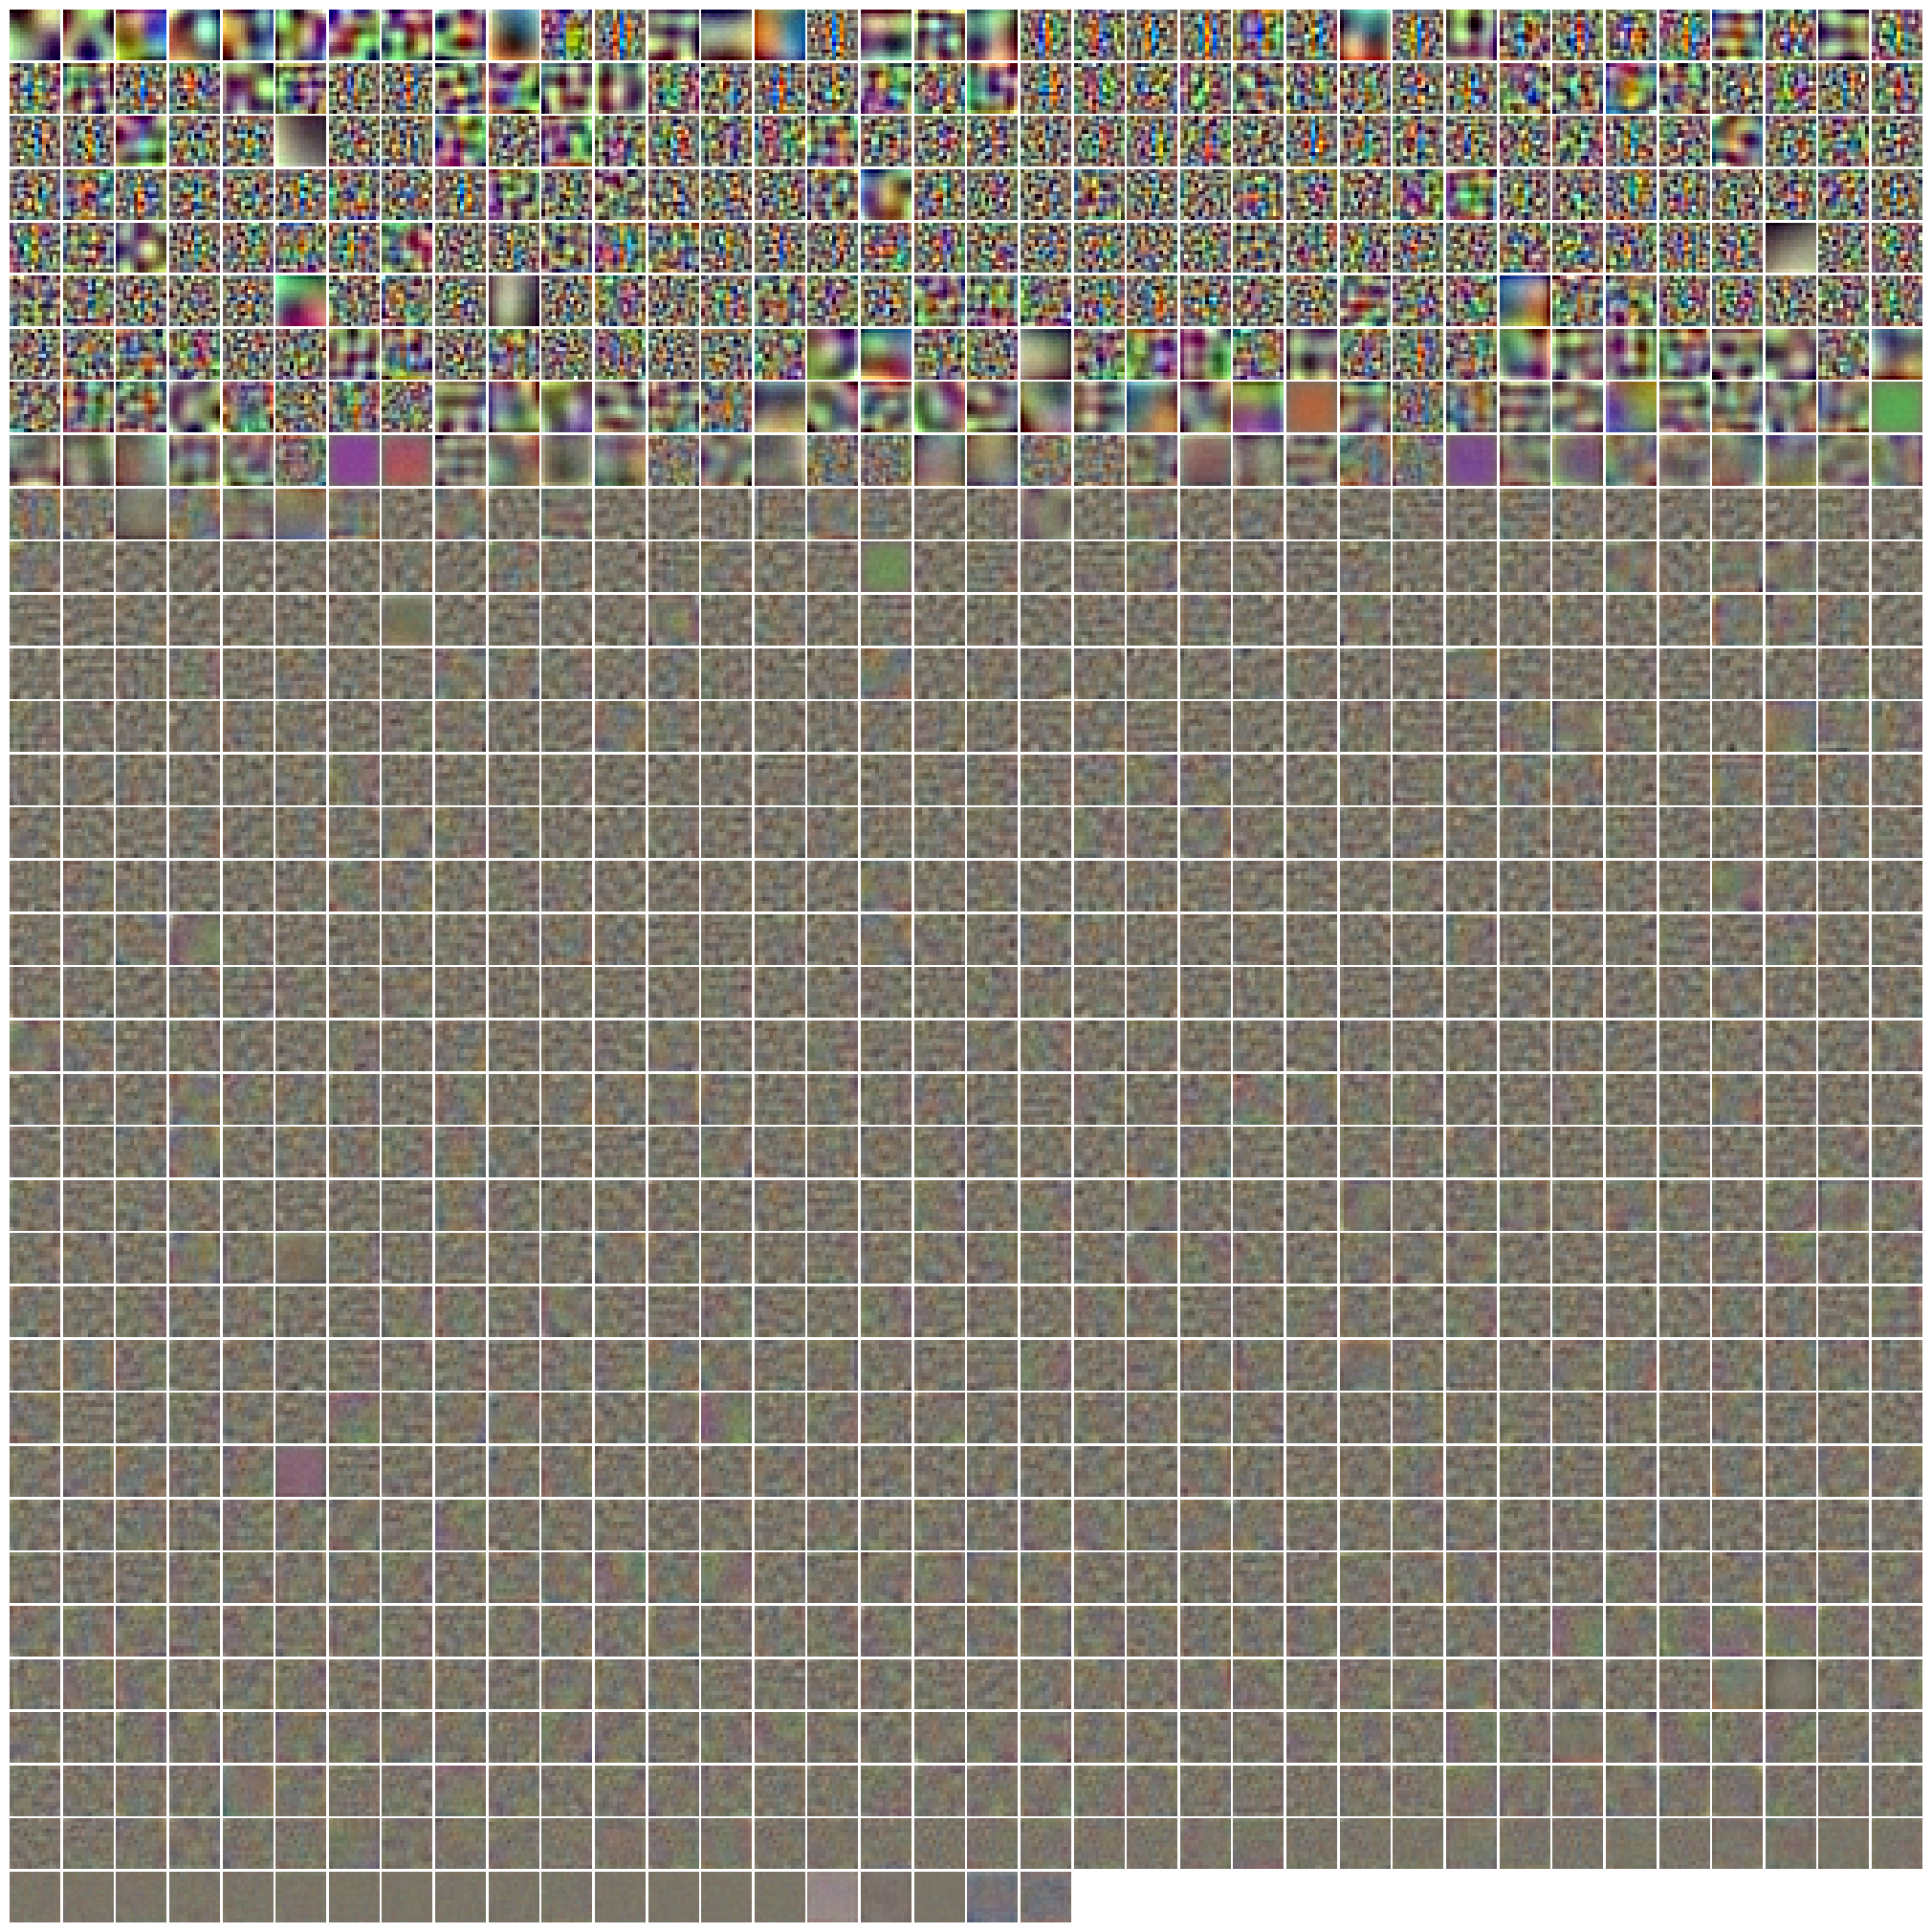

In [18]:
t = params.vision.patch_embedding.reshape(1280, 14, 14, 3).detach().cpu().float()

# Scale up by the presumed (Glorot) initialisation scale of t, then rescale to image
t = (t
    * config.vision.patch_size * (3**.5) * tensor(config.vision.image_std)
    + tensor(config.vision.image_mean)
).clip(0, 1)

# Sort by standard deviation
t = t[torch.argsort(-t.std(dim=(1,2,3)))]

d = int(np.ceil(1280**.5))
# d = 20
_, axs = plt.subplots(d, d, figsize=(20, 20))
for tt, ax in zip(t, axs.flatten()):
    ax.imshow(tt)
for ax in axs.flatten():
    ax.axis("off")
plt.subplots_adjust(0, 0, 1, 1, wspace=0.05, hspace=0.05)
save("patch_embedding")

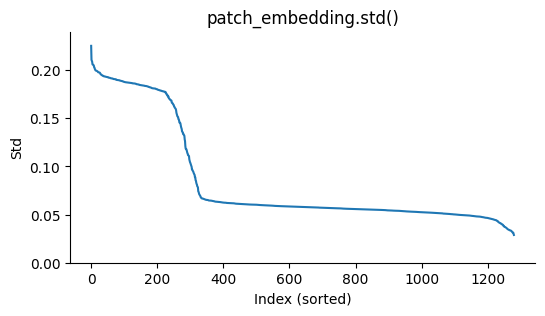

In [19]:
_, ax = plt.subplots(figsize=(6, 3))
ax.plot(t.std(dim=(1,2,3)))
ax.set_title("patch_embedding.std()")
ax.set_ylabel("Std")
ax.set_xlabel("Index (sorted)")
ax.set_ylim((0, 0.24))
save("patch_embedding_std")

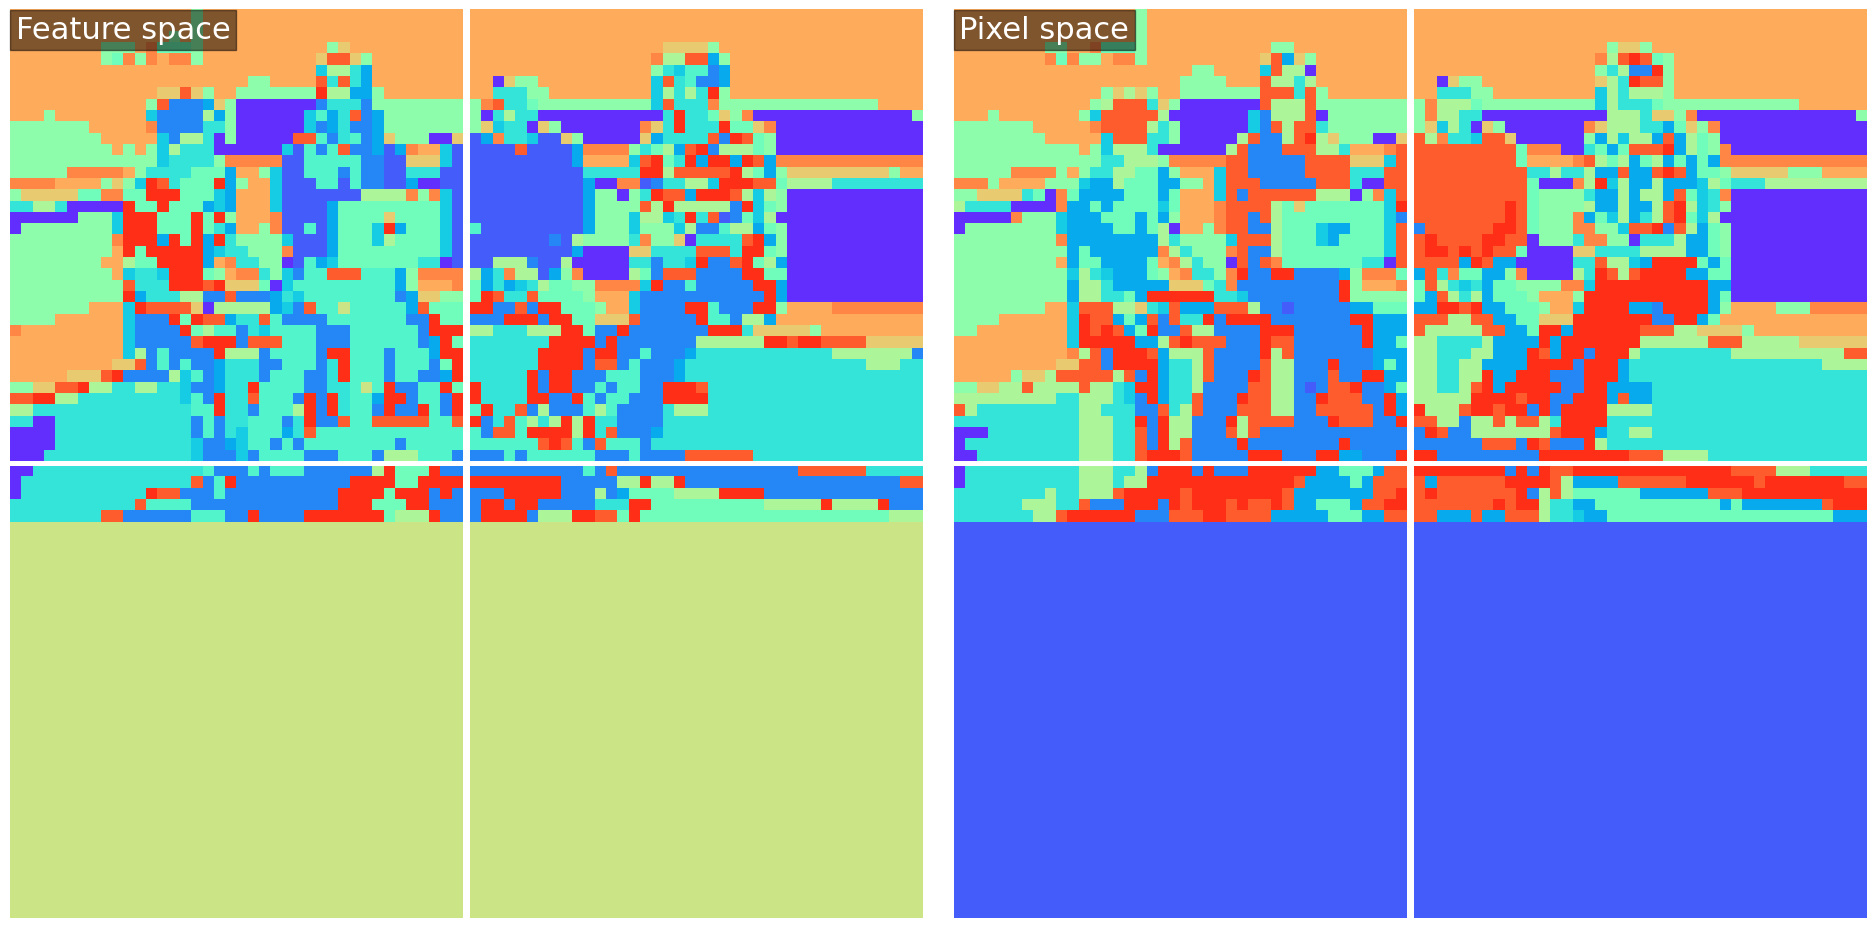

In [20]:
image_embedded = (
    inputs.image.to(params.vision.patch_embedding.dtype) @ params.vision.patch_embedding.T
)
fig = plt.figure(figsize=(24, 11.8))
for name, z, gtile in zip(["feature", "pixel"],
                          [image_embedded, inputs.image],
                          matplotlib.gridspec.GridSpec(1, 2, wspace=0.03, hspace=0.0)):
    torch.manual_seed(112233)
    ids, centroids = kmeans(z.flatten(end_dim=-2), 16, steps=100)
    c = tensor(sns.color_palette("rainbow", n_colors=centroids.shape[0]))[ids.reshape(z.shape[:-1]).cpu()]
    for i, ctile, g in zip(range(4), c.reshape(4, 40, 40, 3), matplotlib.gridspec.GridSpecFromSubplotSpec(
            2, 2, subplot_spec=gtile, wspace=0.01, hspace=0.01)):
        ax = fig.add_subplot(g)
        ax.imshow(ctile)
        ax.axis("off")
        if i == 0:
            ax.text(0, 0, f"{name.capitalize()} space", va="top", color="white", fontsize=22
                ).set_bbox(dict(facecolor="k", alpha=.5))
save("image_embedded_kmeans")

### Positional embedding

In [21]:
print("positional_embedding.shape", tuple(params.vision.positional_embedding.shape))

positional_embedding.shape (8, 4, 1600, 1280)


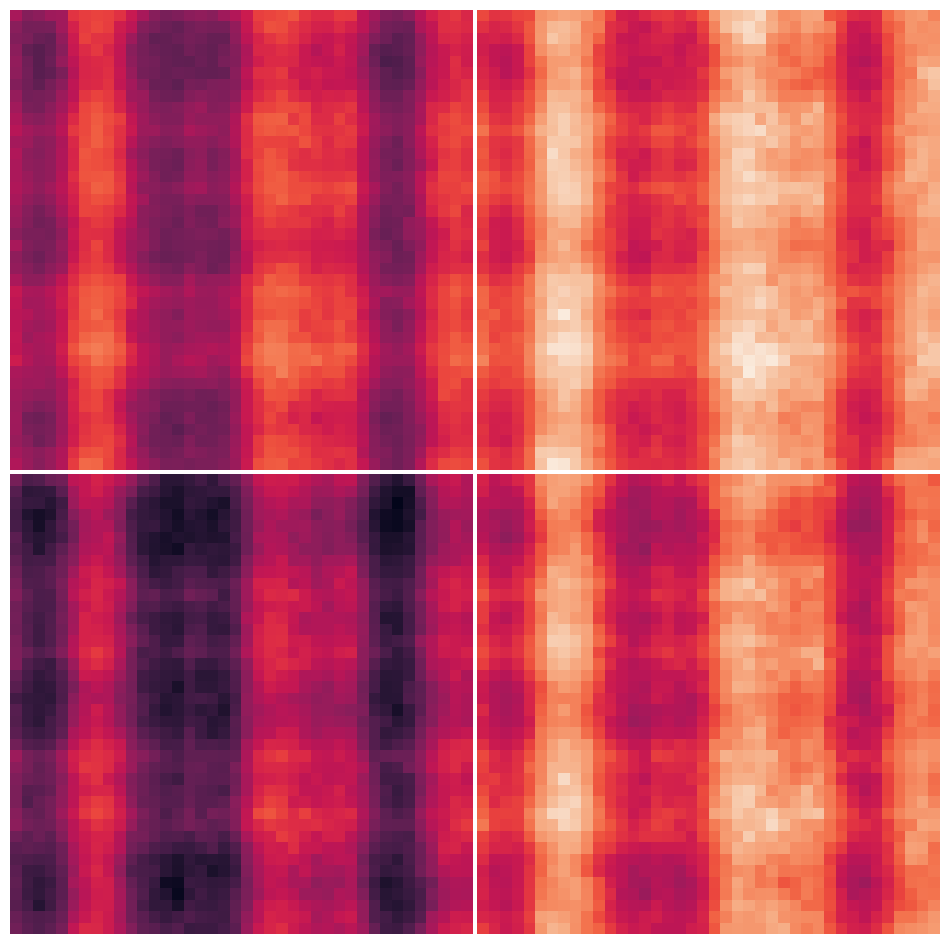

In [22]:
layer_idx, head_idx = 0, 4  # 6,6

positional_embedding = params.vision.positional_embedding[inputs.aspect_ratio_id]
positional_embedding = F.layer_norm(positional_embedding, positional_embedding.shape[-1:], *params.vision.pre_norm)
layer = params.vision.layers_1[layer_idx]
a = (positional_embedding @ layer.attn_q.T).unflatten(-1, (config.vision.heads, -1))[..., head_idx, :]
b = (positional_embedding @ layer.attn_k.T).unflatten(-1, (config.vision.heads, -1))[..., head_idx, :]
m = torch.einsum("ash,bdh->asbd", a, b).reshape(4, 40, 40, 4, 40, 40)
img = m.mean(dim=(0, 1, 2)).cpu().float()

for itile, ax in quadplot(img):
    sns.heatmap(itile, ax=ax, vmin=img.min(), vmax=img.max(), cbar=False)
save("positional_embedding_attn_average")

### Vision transformer - self-attention

In [23]:
# Save the single-tile image
tile = 0
itile = (
    inputs.image[tile].reshape(40, 40, 14, 14, 3)
    .permute(0, 2, 1, 3, 4).flatten(0, 1).flatten(1, 2)
    .cpu().float()
)
itile = (itile * tensor(config.vision.image_std) + tensor(config.vision.image_mean))
matplotlib.image.imsave("img/attention_tile.png", itile.numpy())

In [24]:
attn_log = []
_torch_scaled_dot_product_attention = F.scaled_dot_product_attention
def _logging_attn(q: Tensor, k: Tensor, v: Tensor, attn_mask: Tensor) -> Tensor:
    attn_log.append((q.detach().cpu().float(), k.detach().cpu().float()))
    return _torch_scaled_dot_product_attention(q, k, v, attn_mask=attn_mask)

with um.patch("torch.nn.functional.scaled_dot_product_attention", _logging_attn):
    generate(config, params, inputs, n_generated=0)

In [25]:
layer = 16
head = 3

def attn_map(q: Tensor, k: Tensor) -> Tensor:
    n = 6404
    a = (q[:, :, :n] @ k[:, :, :n].transpose(-1, -2)) / q.shape[-1]**.5
    return a.softmax(-1).squeeze(0)

a = attn_map(*attn_log[layer])

# Remove cls token
a = a.reshape(16, 4, 1601, 4, 1601)[:, :, 1:, :, 1:].reshape(16, 4, 40, 40, 4, 40, 40)

# Save attention map
data = a[head, tile, :, :, tile, : :].contiguous().numpy()
print(data.size, "elements")
print(f"{(4 * data.size)/2**20:.1f} MiB")
data.flatten().tofile("img/attention.bin")

2560000 elements
9.8 MiB


### Vision transformer - residual evolution

In [26]:
hiddens = []
_vision_transformer = vision_transformer
def _logging_vision_transformer(*args, **kwargs) -> list[Tensor]:
    out = _vision_transformer(*args, **kwargs)
    hiddens.extend(out)
    return out

with um.patch("__main__.vision_transformer", _logging_vision_transformer):
    generate(config, params, inputs, n_generated=0)
hiddens = torch.stack(hiddens)
hiddens = hiddens.reshape(-1, 4, 1608, 1280)[:, :, 1:1601].reshape(-1, 4, 40, 40, 1280)

In [27]:
z = F.rms_norm(hiddens, (1280,))
torch.manual_seed(12345)
ids, centroids = kmeans(z.flatten(end_dim=-2), clusters=128, steps=100)
c = tensor(sns.color_palette("rainbow", n_colors=centroids.shape[0]))[ids.reshape(z.shape[:-1]).cpu()]

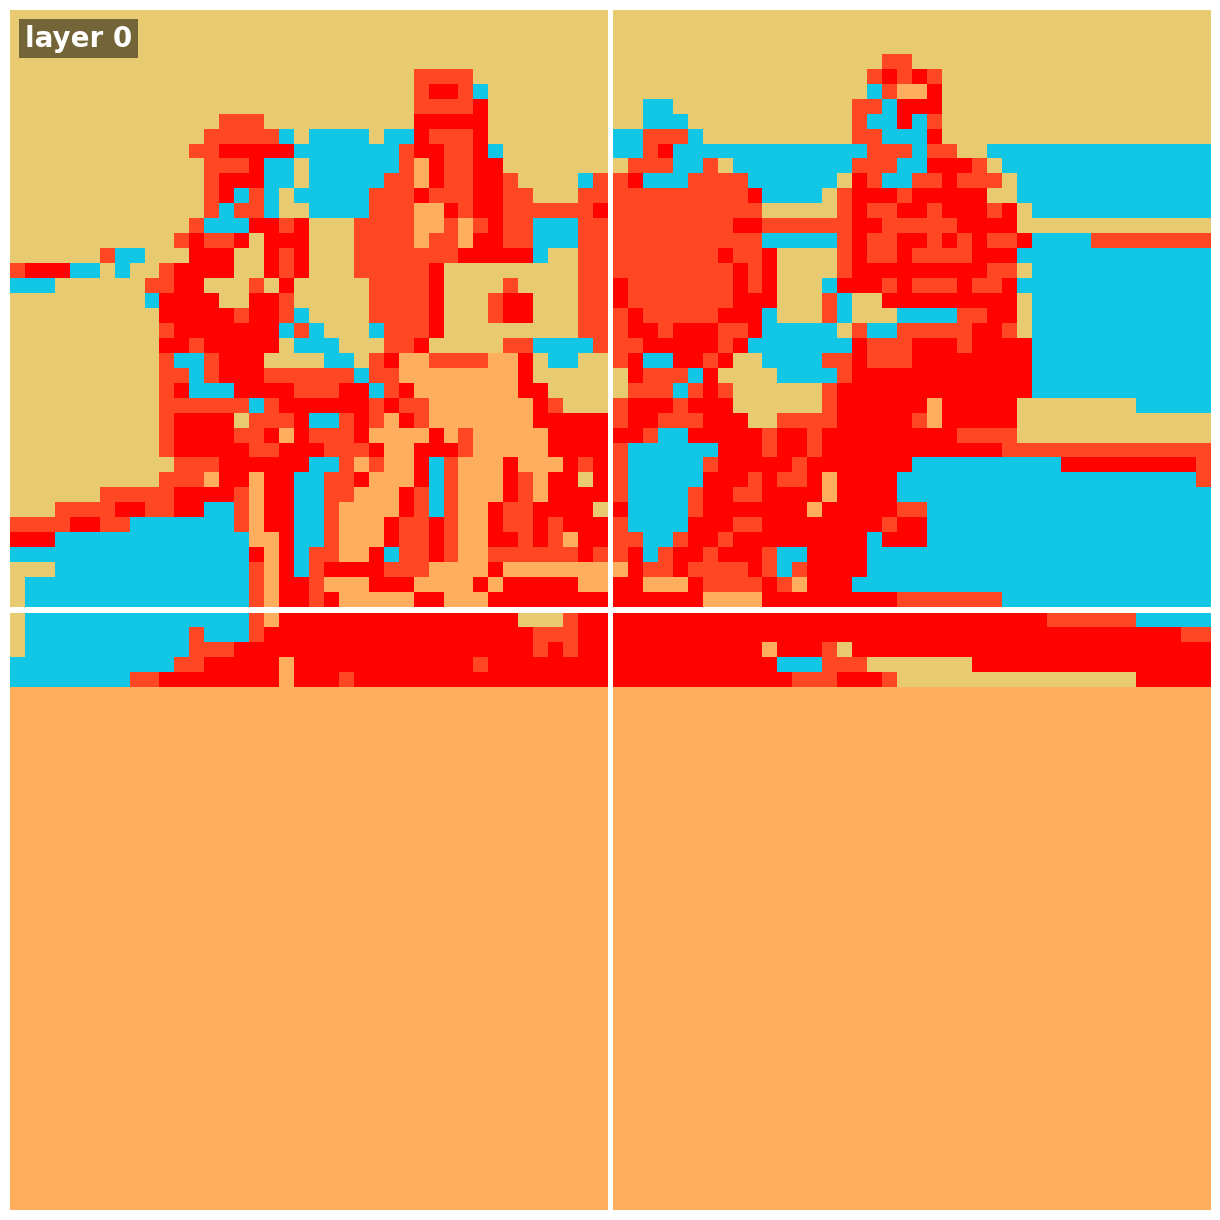

In [28]:
axs = [ax for _, ax in quadplot(range(4))]
text = axs[0].text(.5, .5, f"layer 0", va="top", color="white", fontsize=20, fontweight="bold")
text.set_bbox(dict(facecolor="k", alpha=0.5, lw=0))
def draw(i: int) -> None:
    text.set_text(f"layer {i}")
    for ctile, ax in zip(c.movedim(1, 0), axs):
        ax.imshow(ctile[i])
draw(0)
axs[0].figure.subplots_adjust(left=0, bottom=0, right=1, top=1)

animation = matplotlib.animation.FuncAnimation(axs[0].figure, draw, range(c.shape[0]))
animation.save("img/vision_transformer_state.gif", matplotlib.animation.PillowWriter(fps=4))
# animation.save("img/vision_transformer_state.mp4", matplotlib.animation.FFMpegWriter(fps=4))

### Cross attention

In [36]:
config.vision.taps

[3, 7, 15, 23, 30]

In [29]:
attn_log = []
_torch_scaled_dot_product_attention = F.scaled_dot_product_attention
def _logging_attn(q: Tensor, k: Tensor, v: Tensor, **args: Any) -> Tensor:
    if args.get("enable_gqa") and k.shape[-2] == 6404:
        attn_log.append((q.squeeze(0).detach().cpu().float(), k.squeeze(0).detach().cpu().float()))
    return _torch_scaled_dot_product_attention(q, k, v, **args)

with um.patch("torch.nn.functional.scaled_dot_product_attention", _logging_attn):
    out = generate(config, params, inputs, n_generated=18)
print(tokenizer.decode(out.tolist()))

What colour shirt is the person to the left of the laptop wearing?\nassistant

The person to the left of the laptop is wearing a blue-green t-shirt. The


62400 elements
0.2 MiB


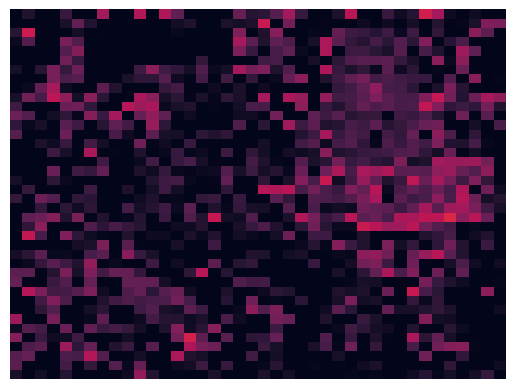

In [30]:
q = torch.stack(
    [torch.concat([attn_log[i][0] for i in range(j, len(attn_log), 8)], dim=1)
     for j in range(8)]
) # (layer, head, seq, dim)
k = torch.stack(
    [attn_log[j][1] for j in range(8)]
) # (layer, head, size, dim)

# Compute all the cross-attention maps in one go
a = torch.einsum("nHhsd, nHtd -> nHhst", q.reshape(8, 8, 4, -1, 128), k).flatten(1, 2)
a /= 128**.5
a = a.softmax(-1)
a = a.unflatten(-1, (4, 1601))[..., 1:].unflatten(-1, (40, 40))

# Save attention map (mean over heads in the layer)
tile = 0
layer = 6
data = a[layer].mean(0)[:, tile, :, :].contiguous().numpy()
print(data.size, "elements")
print(f"{(4 * data.size)/2**20:.1f} MiB")
data.flatten().tofile("img/cross_attention.bin")
Path("img/cross_attention.json").write_text(
    json.dumps(dict(
        layer=layer,
        tokens=[tokenizer.id_to_token(i).replace("Ġ", " ").replace("Ċ", "\\n")
                for i in out[:-1].tolist()],  # (no map available for the last token)
    ))
)

# Check
token = 30
_, ax = plt.subplots()
sns.heatmap(a[layer].mean(0)[token, tile], norm=matplotlib.colors.LogNorm(1/(10*4*40*40), 1),
            cbar=False, ax=ax)
ax.axis("off");